# **Checking data exchange**

In [1]:
import numpy as np
import pandas as pd

import json
import pickle

from multiprocessing.pool import Pool
import io

from tqdm.notebook import trange

import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
SEEDS = [42, 1234, 1867, 613, 1001]
SHARING_METHODS = ["all_data", "alters", "zopt"]
SHARING_METHODS_NAMES = ["all data", "alters", "zopt"]

In [3]:
SIMULATION_RESULTS_ROOT = "../../02_data/01_simulation_results/"
MEETING_PATH = "../../02_data/03_meeting_data/"
VEH_LIST_PATH = "../../02_data/veh_list.json"
PARKING_DEF_PATH = "../../01_simulation/02_scenario/parking_areas.add.xml"

UTILITY_RESULT_PATH = "../../02_data/06_eval_utilities/"

## Size of Shared Dataset

**Payload size:**
- timestamp: 128 bit
- position: uint32 -> 32 bit
- occupancy: float32 -> 32 bit
- *total:* 192 bit

In [4]:
PAYLOAD_SIZE = 192 #[bit]

In [5]:
def get_data_size(data_exchange):
    if "data" in data_exchange:
        sd_df = pd.read_json(io.StringIO(data_exchange["data"]))
        return len(sd_df)
    return 0

In [ ]:
data_sizes = {}

for sm in SHARING_METHODS:
    counts = []
    for seed in SEEDS:
        with open(f"{MEETING_PATH}/{sm}/{seed}/shared_data.json") as f:
            shared_data = json.load(f)["shared_data"]
        with Pool(16) as pool:
            data_size = pool.map(get_data_size, shared_data)
        counts = counts + data_size
    data_sizes[sm] = np.array(counts)

In [ ]:
for sm in SHARING_METHODS:
    print(f"avg size of {sm:9}: {np.mean(data_sizes[sm]):10.4f}")
for sm in SHARING_METHODS:
    print(f"min size of {sm:9}: {np.min(data_sizes[sm]):10.4f}")
for sm in SHARING_METHODS:
    print(f"max size of {sm:9}: {np.max(data_sizes[sm]):10.4f}")

In [ ]:
long_df_size = pd.DataFrame()
sharing_methods, datasize = [], []
for sm, sm_name in zip(SHARING_METHODS, SHARING_METHODS_NAMES):
    sharing_methods += [sm_name]*len(data_sizes[sm])
    datasize += data_sizes[sm].tolist()
long_df_size["sharing method"] = sharing_methods
long_df_size["datasize"] = datasize
long_df_size["payload size [kiB]"] = long_df_size["datasize"]*192/8/1024

In [ ]:
plt.figure(figsize=[4,3])
sns.boxplot(data=long_df_size, x="sharing method", y="payload size [kiB]",
            width=.2, whis=[1, 99], legend=True, fliersize=2.0, flierprops={"alpha": 0.2},
            medianprops={"linewidth":3}, color="tab:blue", boxprops=dict(alpha=.6))
plt.xlabel("")

In [ ]:
long_df_size.groupby("sharing method").mean()

In [ ]:
long_df_size

## Data Utility

In [5]:
#reading *test* vehicles:

with open(VEH_LIST_PATH) as f:
    veh_list  = json.load(f)

test_vehicles = veh_list["test_vehs"]

In [6]:
def combine_commuters(veh_id):
    if veh_id.startswith("carIn"):
        return veh_id.split(":")[0]
    return veh_id

#reading moving simulation data:

m_data = pd.DataFrame()
for s in SEEDS:
    filename = f"{SIMULATION_RESULTS_ROOT}/vehicle_positions_{s}.csv"
    mf = pd.read_csv(filename)
    mf["seed"] = [s]*len(mf)
    m_data = pd.concat([m_data, mf])

m_data["veh_id"] = m_data["veh_id"].apply(combine_commuters)
m_data = m_data[m_data["veh_id"].isin(test_vehicles)]
m_data = m_data[~m_data["edge"].str.startswith(":")]

In [7]:
parking_df = pd.read_xml(PARKING_DEF_PATH, xpath="parkingArea")
parking_df = parking_df.set_index("id")
p_edges = []
for _,r in parking_df.iterrows():
    p_edges.append(r["lane"].split("_")[0])
parking_df["edge"] = p_edges

def add_edges_to_parkings(vehicle_df, parking_df):
    parkings = []
    for _,r in vehicle_df.iterrows():
        parkings.append(parking_df.loc[r.parking_id]["edge"])
    vehicle_df["edge"] = parkings
    return vehicle_df

In [8]:
def get_useful_size(args):
    dx, mv_data = args
    utility_percent = 0
    if "data" in dx:
        sd_df = pd.read_json(dx["data"])
        veh_id = dx["receiver"]
        mtime = dx["time"]
        
        #filtering the receiver's data which is in the next 5 minutes after the meeting:
        veh_moves = mv_data[mv_data["veh_id"] == veh_id]
        veh_moves = veh_moves[veh_moves["time"]>mtime]
        veh_moves = veh_moves[veh_moves["time"]<=mtime+5*60]

        sd_df = add_edges_to_parkings(sd_df, parking_df)
        
        usefuls = 0
        vc = sd_df["edge"].value_counts()
        for edge in veh_moves["edge"].unique():
            if edge in vc:
                usefuls += vc[edge]
        if len(sd_df) != 0:
            utility_percent = usefuls/len(sd_df)
        else:
            utility_percent = -1
    return utility_percent

In [ ]:
for sm_i in trange(len(SHARING_METHODS)):
    sm = SHARING_METHODS[sm_i]
    for seed in SEEDS:
        with open(f"{MEETING_PATH}/{sm}/{seed}/shared_data.json") as f:
            shared_data = json.load(f)["shared_data"]
        with Pool(16) as pool:
            utils = pool.map(get_useful_size, zip(shared_data, [m_data]*len(shared_data)))
        shared_utils = {"local_evaluation": utils}
        with open(f"{UTILITY_RESULT_PATH}/utilities_{sm}_{seed}.json", "w") as f:
            json.dump(shared_utils, f)

  0%|          | 0/3 [00:00<?, ?it/s]

In [ ]:
long_utility_df = pd.DataFrame()
sharing_methods, values = [], []
for sm, sm_name in zip(SHARING_METHODS, SHARING_METHODS_NAMES):
    for seed in SEEDS:
        with open(f"{UTILITY_RESULT_PATH}/utilities_{sm}_{seed}.json") as f:
            data_utilities = json.load(f)["local_evaluation"]
        sharing_methods += [sm_name]*len(data_utilities)
        values += (np.clip(data_utilities, 0, 1)*100).tolist()
long_utility_df["sharing method"]=sharing_methods
long_utility_df["utility %"] = values

In [ ]:
plt.figure(figsize=[6,3])
sns.boxplot(data=long_utility_df, x="sharing method", y="utility %",
            width=.2, whis=[1, 99], legend=True, fliersize=2.0, flierprops={"alpha": 0.2},
            medianprops={"linewidth":3}, color="tab:blue", boxprops=dict(alpha=.6))
plt.xlabel("")

In [ ]:
long_utility_df.groupby("sharing method").mean()

In [ ]:
long_df_size["utility"] = long_utility_df["utility %"]
long_df_size["specific_utility"] = long_df_size["utility"]/long_df_size["payload size [kiB]"]

In [36]:
long_df_size.to_csv(f"{UTILITY_RESULT_PATH}/utility_sizes.csv", index=False)

In [4]:
long_df_size = pd.read_csv(f"{UTILITY_RESULT_PATH}/utility_sizes.csv")

In [5]:
long_df_size.groupby("sharing method").mean()

,datasize,payload size [kiB],utility,specific_utility
sharing method,,,,
all data,1061.507753,24.879088,10.993753,22.145139
alters,719.807137,16.870480,12.478964,23.503370
zopt,50.364898,1.180427,17.047145,41.798850


In [7]:
plot_method, plot_value, plot_valuetype = [],[],[]
for i,r in long_df_size.iterrows():
    plot_method.append(r["sharing method"])
    plot_value.append(r["payload size [kiB]"])
    plot_valuetype.append("payload size [kiB]")
    
    plot_method.append(r["sharing method"])
    plot_value.append(r["utility"])
    plot_valuetype.append("utility %")

In [8]:
plot_df = pd.DataFrame()
plot_df["data selection method"] = plot_method
plot_df["value"] = plot_value
plot_df["value type"] = plot_valuetype

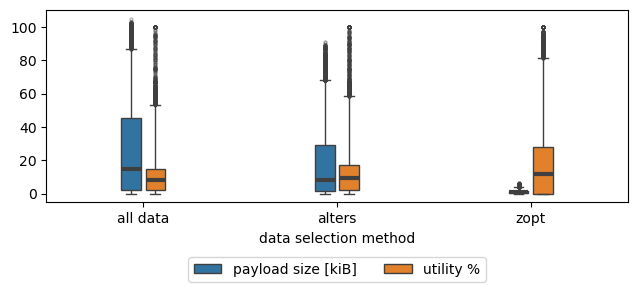

In [14]:
plt.figure(figsize=(7.5, 2.5))
sns.boxplot(data=plot_df, x="data selection method", y="value", hue="value type",
            width=0.25, gap=0.2, whis=[1, 99], legend=True, fliersize=2.0, flierprops={"alpha": 0.2},
                medianprops={"linewidth":3})
plt.ylabel("")
plt.legend(title="", ncols=2, loc="lower center", bbox_to_anchor=(0.5, -.45))

## Meeting probabilities

In [31]:
#reading *test* vehicles:

with open(VEH_LIST_PATH) as f:
    veh_list  = json.load(f)

test_vehicles = veh_list["test_vehs"]

In [32]:
def combine_commuters(veh_id):
    if veh_id.startswith("carIn"):
        return veh_id.split(":")[0]
    return veh_id

#reading moving simulation data:

m_data = pd.DataFrame()
for s in SEEDS:
    filename = f"{SIMULATION_RESULTS_ROOT}/vehicle_positions_{s}.csv"
    mf = pd.read_csv(filename)
    mf["seed"] = [s]*len(mf)
    m_data = pd.concat([m_data, mf])

m_data["veh_id"] = m_data["veh_id"].apply(combine_commuters)
m_data = m_data[m_data["veh_id"].isin(test_vehicles)]
m_data = m_data[~m_data["edge"].str.startswith(":")]

In [33]:
parking_df = pd.read_xml(PARKING_DEF_PATH, xpath="parkingArea")
parking_df = parking_df.set_index("id")
p_edges = []
for _,r in parking_df.iterrows():
    p_edges.append(r["lane"].split("_")[0])
parking_df["edge"] = p_edges

def add_edges_to_parkings(vehicle_df, parking_df):
    parkings = []
    for _,r in vehicle_df.iterrows():
        parkings.append(parking_df.loc[r.parking_id]["edge"])
    vehicle_df["edge"] = parkings
    return vehicle_df

In [37]:
veh_ids, movement_starts, movement_ends, seeds, lengths = [], [], [], [], []

veh_list = m_data["veh_id"].unique()

for veh in veh_list:
    veh_mov = m_data[m_data["veh_id"] == veh]

    movement_start = 0
    movement_end = 0
    seed = 0
    edge_set = set()
    
    old_vehid = veh
    for i,mov in veh_mov.iterrows():
        if (mov["time"] > movement_end+5*60) and (i!=0):
            veh_ids.append(old_vehid)
            movement_starts.append(movement_start)
            movement_ends.append(movement_end)
            seeds.append(seed)
            lengths.append(len(edge_set))

            movement_start = mov["time"]
            old_vehid = mov["veh_id"]
            edge_set = set()
        elif i == 0:
            movement_start = mov["time"]

        edge_set.add(mov["edge"])    
        movement_end = mov["time"]
        seed = mov["seed"]

In [38]:
movement_lengths = pd.DataFrame()
movement_lengths["veh_id"] = veh_ids
movement_lengths["movement_start"] = movement_starts
movement_lengths["movement_end"] = movement_ends
movement_lengths["seed"] = seeds
movement_lengths["length"] = lengths

In [39]:
def get_movement_id(movement_lengths, veh_id, dx_time, seed):
    mov_filt = movement_lengths[movement_lengths["seed"] == seed]
    mov_filt = mov_filt[mov_filt["veh_id"] == veh_id]
    for i,r in mov_filt.iterrows():
        if (r["movement_start"] <= dx_time) and (dx_time <= r["movement_end"]):
            return i
    return None

In [40]:
sm = SHARING_METHODS[0]
num_exchanges = [0]*len(movement_lengths)

for seed in SEEDS:
    with open(f"{MEETING_PATH}/{sm}/{seed}/shared_data.json") as f:
        shared_data = json.load(f)["shared_data"]
        
        for exi, data_exchange in enumerate(shared_data):
            dx_time = data_exchange["time"]
            vehicle = data_exchange["sender"]
            index_dx = get_movement_id(movement_lengths, vehicle, dx_time, seed)
            if not(index_dx is None):
                num_exchanges[index_dx] += 1
            else:
                pass
                #print(f"{exi}: vehicle: {vehicle}, time: {dx_time}, seed: {seed}")

In [41]:
movement_lengths["num_meetings"] = num_exchanges

In [42]:
movement_lengths.to_csv(f"{UTILITY_RESULT_PATH}/meeting_probs.csv", index=False)

In [46]:
movement_lengths["meeting_rate"] = movement_lengths["num_meetings"] / movement_lengths["length"]
np.mean(movement_lengths["meeting_rate"])

0.5207298947369341